In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks')

# New section

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import seaborn as sns
import tensorflow as tf
import scipy
from TrajectoryObject import TrajectoryObj
from FileIO import write_trajectory, read_trajectory, read_mosaic, read_localization, read_andi2_trajectory_label
from andi_datasets.models_phenom import models_phenom
from andi_datasets.datasets_phenom import datasets_phenom
from andi_datasets.utils_trajectories import plot_trajs
from andi_datasets.utils_challenge import label_continuous_to_list
from stochastic import random as strandom

%load_ext autoreload
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

2024-04-22 15:16:53.967485: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-22 15:16:53.969710: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-22 15:16:53.993285: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 15:16:54.536429: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/junwoo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SHUFFLE = True
MAX_EPOCHS = 10000
BATCH_SIZE = 1024
PATIENCE = 100
N = 10
T = 200
L = None

NB_INPUT_FEATURES = 1
SEARCH_WIDTH = 2
WINDOW_WIDTHS = [36, 48, 60, 72, 84]
SHIFT_WIDTH = 10

In [3]:
def uncumulate(xs:np.ndarray):
    assert xs.ndim == 1
    uncum_list = [0.]
    for i in range(1, len(xs)):
        uncum_list.append(xs[i] - xs[i-1])
    return np.array(uncum_list)

In [4]:
def alphas_2_cps(alpha_seq):
    cp_seq = []
    alpha = alpha_seq[0]
    for next_alpha in alpha_seq[1:]:
        if alpha != next_alpha:
            cp_seq.append(1)
        else:
            cp_seq.append(0)
        alpha = next_alpha
    cp_seq.append(0)
    return np.array(cp_seq)

In [5]:
def make_signal(x_pos, y_pos, win_widths, search_width):
    all_vals = []
    for win_width in win_widths:
        vals = []
        for checkpoint in range(int(win_width/2), len(x_pos) - int(win_width/2)):
            xs = x_pos[checkpoint - int(win_width/2) : checkpoint + int(win_width/2)]
            ys = y_pos[checkpoint - int(win_width/2) : checkpoint + int(win_width/2)]

            xs1 = xs[:int(len(xs)/2)] - float(xs[:int(len(xs)/2)][0])
            xs2 = xs[int(len(xs)/2):] - float(xs[int(len(xs)/2):][0])

            ys1 = ys[:int(len(ys)/2)] - float(ys[:int(len(ys)/2)][0])
            ys2 = ys[int(len(ys)/2):] - float(ys[int(len(ys)/2):][0])

            std_xs1 = np.std(xs1)
            std_xs2 = np.std(xs2)
            std_ys1 = np.std(ys1)
            std_ys2 = np.std(ys2)

            surface_xs1 = abs(np.sum(xs1)) / win_width
            surface_xs2 = abs(np.sum(xs2)) / win_width
            surface_ys1 = abs(np.sum(ys1)) / win_width
            surface_ys2 = abs(np.sum(ys2)) / win_width


            xs1 = np.cumsum(abs(xs1)) #* surface_xs1
            xs2 = np.cumsum(abs(xs2)) #* surface_xs2
            ys1 = np.cumsum(abs(ys1)) #* surface_ys1
            ys2 = np.cumsum(abs(ys2)) #* surface_ys2


            xs_max_val = max(np.max(abs(xs1)), np.max(abs(xs2)))
            xs1 = xs1 / xs_max_val
            xs2 = xs2 / xs_max_val
            xs1 = xs1 / win_width
            xs2 = xs2 / win_width

            ys_max_val = max(np.max(abs(ys1)), np.max(abs(ys2)))
            ys1 = ys1 / ys_max_val
            ys2 = ys2 / ys_max_val
            ys1 = ys1 / win_width 
            ys2 = ys2 / win_width

            vals.append(abs(np.sum(xs1 - xs2 + ys1 - ys2)) 
                       * (max(std_xs1, std_xs2) / min(std_xs1, std_xs2)) 
                             * (max(std_ys1, std_ys2) / min(std_ys1, std_ys2)))

        vals = np.concatenate((np.zeros(int(win_width/2)), vals))
        vals = np.concatenate((vals, np.zeros(int(win_width/2))))

        vals = np.array(vals)
        all_vals.append(vals)

    new_all_vals = []
    for i in range(len(all_vals)):
        tmp = []
        for j in range(len(all_vals[i])):
            if j < search_width:
                tmp.append(all_vals[i][j] * ((search_width * 2) + 1))
            elif j > len(all_vals[i]) - 1 - search_width:
                tmp.append(all_vals[i][j] * ((search_width * 2) + 1))
            else:
                tmp.append(np.sum(all_vals[i][j-search_width:j+search_width+1]))
        tmp = np.array(tmp)
        new_all_vals.append(tmp)
    new_all_vals = np.array(new_all_vals)
    all_vals = np.array(new_all_vals)

    tmp = []
    for j in range(len(all_vals[0])):
        tmp_sum = 0
        count = 0
        for i in range(len(all_vals)):
            if all_vals[i][j] != 0:
                tmp_sum += all_vals[i][j]
                count += 1
        if count == 0:
            tmp.append(0)
        else:
            tmp.append(tmp_sum / count)
    all_vals = np.array(tmp)
    all_vals = all_vals / np.max(all_vals)
    return all_vals

In [6]:
def chop_with_shift2(signal_seq, label_seq):
    chopped_signals = []
    chopped_labels = []
    for i in range((SHIFT_WIDTH//2), len(signal_seq) - (SHIFT_WIDTH//2)):
        chopped_signals.append(signal_seq[i - (SHIFT_WIDTH//2) : i + (SHIFT_WIDTH//2)])
        chopped_labels.append(label_seq[i])
    return chopped_signals, chopped_labels

In [7]:
def chop_with_shift(signal_seq, changepoints=None, count_0=None, count_1=None):
    chopped_signals = []
    chopped_labels = []
    std_signal = np.std(signal_seq)
    mean_signal = np.mean(signal_seq)
    if changepoints is not None:
        if len(changepoints) != 0:
            for cp in changepoints:
                if cp >= (SHIFT_WIDTH//2) and cp < len(signal_seq) - (SHIFT_WIDTH//2):
                    while True:
                        random_selec = np.random.randint(0, T)
                        if random_selec not in changepoints:
                            if random_selec >= (SHIFT_WIDTH//2) and random_selec < len(signal_seq) - (SHIFT_WIDTH//2):
                                tmp1 = np.concatenate((signal_seq[random_selec - (SHIFT_WIDTH//2) : random_selec + (SHIFT_WIDTH//2)], [mean_signal, std_signal]))
                                chopped_signals.append(tmp1)
                                chopped_labels.append(0)
                                tmp2 = np.concatenate((signal_seq[cp - (SHIFT_WIDTH//2) : cp + (SHIFT_WIDTH//2)], [mean_signal, std_signal]))
                                chopped_signals.append(tmp2)
                                chopped_labels.append(1)
                            elif random_selec < len(signal_seq) - (SHIFT_WIDTH//2):
                                tmp1 = np.concatenate((signal_seq[random_selec: random_selec + SHIFT_WIDTH], [mean_signal, std_signal]))
                                chopped_signals.append(tmp1)
                                chopped_labels.append(0)
                                tmp2 = np.concatenate((signal_seq[cp - (SHIFT_WIDTH//2) : cp + (SHIFT_WIDTH//2)], [mean_signal, std_signal]))
                                chopped_signals.append(tmp2)
                                chopped_labels.append(1)
                            else:
                                tmp1 = np.concatenate((signal_seq[random_selec - SHIFT_WIDTH: random_selec], [mean_signal, std_signal]))
                                chopped_signals.append(tmp1)
                                chopped_labels.append(0)
                                tmp2 = np.concatenate((signal_seq[cp - (SHIFT_WIDTH//2) : cp + (SHIFT_WIDTH//2)], [mean_signal, std_signal]))
                                chopped_signals.append(tmp2)
                                chopped_labels.append(1)
                            count_0 += 1
                            count_1 += 1
                            break
        else:
            for _ in range(int(T / SHIFT_WIDTH / 4)):
                random_selec = np.random.randint(0, T)
                if random_selec >= (SHIFT_WIDTH//2) and random_selec < len(signal_seq) - (SHIFT_WIDTH//2):
                    tmp1 = np.concatenate((signal_seq[random_selec - (SHIFT_WIDTH//2) : random_selec + (SHIFT_WIDTH//2)], [mean_signal, std_signal]))
                    chopped_signals.append(tmp1)
                    chopped_labels.append(0)
                elif random_selec < len(signal_seq) - (SHIFT_WIDTH//2):
                    tmp1 = np.concatenate((signal_seq[random_selec: random_selec + SHIFT_WIDTH], [mean_signal, std_signal]))
                    chopped_signals.append(tmp1)
                    chopped_labels.append(0)
                else:
                    tmp1 = np.concatenate((signal_seq[random_selec - SHIFT_WIDTH: random_selec], [mean_signal, std_signal]))
                    chopped_signals.append(tmp1)
                    chopped_labels.append(0)
                count_0 += 1
        return np.array(chopped_signals), np.array(chopped_labels), count_0, count_1
    else:
        for i in range(SHIFT_WIDTH//2, len(signal_seq) - SHIFT_WIDTH//2):
            crop = signal_seq[i - SHIFT_WIDTH//2: i + SHIFT_WIDTH//2]
            crop = np.concatenate((crop, [mean_signal, std_signal]))
            chopped_signals.append(crop)
        return np.array(chopped_signals)


In [10]:
input_signals = []
input_labels = []
K_bound = [1e-12, 1000000.0]
alpha_bound = [0, 1.999]
alphas = [0.001, 0.5, 1.0, 1.5, 1.999]
count_0 = 0
count_1 = 0

for step in range(1000):
    if step % 10 == 0: print(step)
    alpha1, alpha2 = np.random.choice(alphas, 2, replace=True)
    trajs_model, labels_model = models_phenom().multi_state(N=N,
                                                            L=L,
                                                            T=T,
                                                            alphas=[alpha1, alpha2],  # Fixed alpha for each state
                                                            Ds=[[0.1, 0.0], [0.1, 0.0]],# Mean and variance of each state
                                                            M=[[0.99, 0.01], [0.01, 0.99]]
                                                           )
    
    for i in range(N):
        signal_seq = make_signal(trajs_model[:, i, 0], trajs_model[:, i, 1], WINDOW_WIDTHS, SEARCH_WIDTH)
        changepoints, alphas_cp, Ds, state_num = label_continuous_to_list(labels_model[:, i, :])
        label_seq = alphas_2_cps(labels_model[:, i, 0])
        
        chop_signal, chop_label, count_0, count_1 = chop_with_shift(signal_seq, changepoints[:-1], count_0, count_1)
        input_signals.extend(chop_signal)
        input_labels.extend(chop_label)

input_signals = np.array(input_signals)
input_labels = np.array(input_labels)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [12]:
print(count_0, count_1)
total = count_0 + count_1
weight_for_0 = (1 / count_0) * (total / 2.0)
weight_for_1 = (1 / count_1) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

print(input_signals.shape, input_labels.shape)
print(class_weight)

319543 15043
(334586, 12) (334586,)
{0: 0.5235383031391706, 1: 11.120986505351325}


In [13]:
input_signals = input_signals.reshape(-1, SHIFT_WIDTH+2, 1)
input_labels = input_labels.reshape(-1, 1)
split_index = int(input_signals.shape[0] * 0.8)
train_input = input_signals[:split_index]
train_label = input_labels[:split_index]
val_input = input_signals[split_index:]
val_label = input_labels[split_index:]

In [14]:
train_tf = tf.data.Dataset.from_tensor_slices((train_input, train_label)).batch(BATCH_SIZE)
val_tf = tf.data.Dataset.from_tensor_slices((val_input, val_label)).batch(BATCH_SIZE)
print(train_tf)
print(val_tf)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 12, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 12, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>


2024-04-22 15:29:27.421589: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-22 15:29:27.433105: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [15]:
class Jaccard(tf.keras.Metric):
    def __init__(self, name='JSC', **kwargs):
        super().__init__(name=name, **kwargs)
        self.true_positives = self.add_variable(
            shape=(),
            initializer='zeros',
            name='JSC_tp'
        )
        self.false_positives = self.add_variable(
            shape=(),
            initializer='zeros',
            name='JSC_fp'
        )
        self.false_negatives = self.add_variable(
            shape=(),
            initializer='zeros',
            name='JSC_fn'
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.keras.ops.cast(y_true, "bool")
        y_pred = tf.keras.ops.cast(tf.math.round(y_pred), "bool")

        tp_values = tf.keras.ops.logical_and(
            tf.keras.ops.equal(y_true, True), tf.keras.ops.equal(y_pred, True))
        tp_values = tf.keras.ops.cast(tp_values, self.dtype)
        
        fp_values = tf.keras.ops.logical_and(
            tf.keras.ops.equal(y_true, False), tf.keras.ops.equal(y_pred, True))
        fp_values = tf.keras.ops.cast(fp_values, self.dtype)
        
        fn_values = tf.keras.ops.logical_and(
            tf.keras.ops.equal(y_true, True), tf.keras.ops.equal(y_pred, False))
        fn_values = tf.keras.ops.cast(fn_values, self.dtype)
        
        tn_values = tf.keras.ops.logical_and(
            tf.keras.ops.equal(y_true, False), tf.keras.ops.equal(y_pred, False))
        tn_values = tf.keras.ops.cast(tn_values, self.dtype)

        self.true_positives.assign(self.true_positives + tf.keras.ops.sum(tp_values))
        self.false_positives.assign(self.false_positives + tf.keras.ops.sum(fp_values))
        self.false_negatives.assign(self.false_negatives + tf.keras.ops.sum(fn_values))

    def result(self):
        return self.true_positives / (self.true_positives + self.false_positives + self.false_negatives)

In [16]:
def compile_and_fit(model, train_tf, val_tf, patience=100):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min',
                                                      restore_best_weights=True,)

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=[tf.keras.metrics.BinaryAccuracy(name='Acc'),
                           Jaccard(name='JSC', dtype=None)]
                 ) 
    
    history = model.fit(x=train_tf,
                        validation_data=val_tf,
                        epochs=MAX_EPOCHS,
                        shuffle=True,
                        callbacks=[early_stopping],
                        class_weight=class_weight,
                        verbose=2)
    return history

In [ ]:
%%time

%autoreload 2
from ConvModel import SPT

model = SPT()
history = compile_and_fit(model, train_tf, val_tf, patience=PATIENCE)

TensorFlow version: 2.16.1
Epoch 1/10000
262/262 - 53s - 204ms/step - Acc: 0.6258 - JSC: 0.0576 - loss: 0.6566 - val_Acc: 0.7523 - val_JSC: 0.0877 - val_loss: 0.6644
Epoch 2/10000
262/262 - 52s - 198ms/step - Acc: 0.7638 - JSC: 0.0780 - loss: 0.6342 - val_Acc: 0.7777 - val_JSC: 0.1005 - val_loss: 0.6624
Epoch 3/10000
262/262 - 53s - 200ms/step - Acc: 0.7974 - JSC: 0.0884 - loss: 0.6226 - val_Acc: 0.8199 - val_JSC: 0.1245 - val_loss: 0.6087
Epoch 4/10000
262/262 - 52s - 198ms/step - Acc: 0.7870 - JSC: 0.0908 - loss: 0.6059 - val_Acc: 0.8227 - val_JSC: 0.1302 - val_loss: 0.5848
Epoch 5/10000
262/262 - 52s - 199ms/step - Acc: 0.7964 - JSC: 0.1005 - loss: 0.5790 - val_Acc: 0.8546 - val_JSC: 0.1542 - val_loss: 0.4902
Epoch 6/10000
262/262 - 52s - 200ms/step - Acc: 0.7919 - JSC: 0.1085 - loss: 0.5539 - val_Acc: 0.8301 - val_JSC: 0.1536 - val_loss: 0.4665
Epoch 7/10000
262/262 - 54s - 206ms/step - Acc: 0.7866 - JSC: 0.1115 - loss: 0.5385 - val_Acc: 0.8173 - val_JSC: 0.1519 - val_loss: 0.4640


TypeError: '>' not supported between instances of 'float' and 'NoneType'

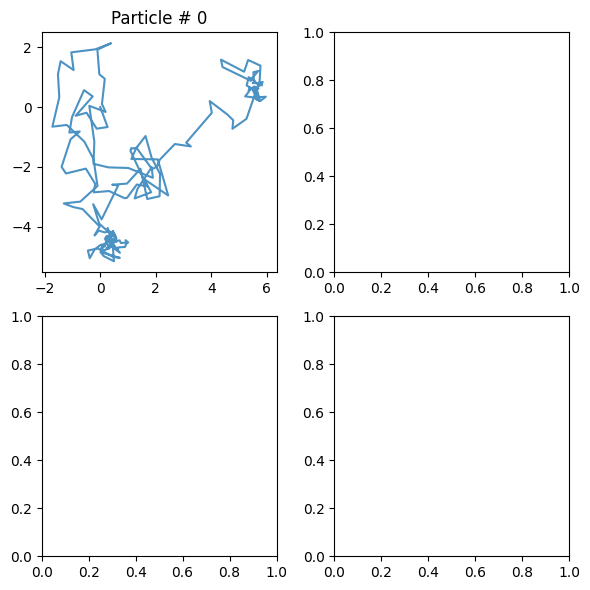

In [28]:
trajs_model, labels_model = models_phenom().multi_state(N=2,
                                                        L=L,
                                                        T=T,
                                                        alphas=[0.8, 1.2],
                                                        Ds=[[0.01, 0.0], [0.1, 0.0]],
                                                        M=[[0.99, 0.01], [0.01, 0.99]]
                                                       )
signal_seq = make_signal(trajs_model[:, 0, 0], trajs_model[:, 0, 1], WINDOW_WIDTHS, SEARCH_WIDTH)
changepoints, alphas_cp, Ds, state_num = label_continuous_to_list(labels_model[:, 0, :])
plot_trajs(trajs_model[:, 0:2, :], L, 1, num_to_plot =2)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


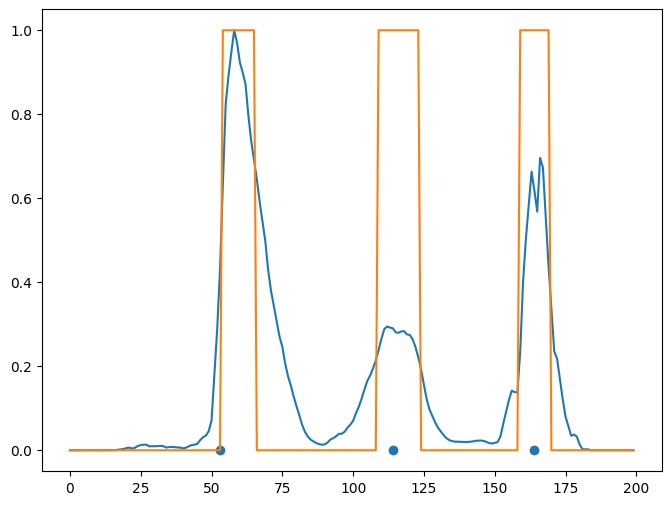

In [29]:
predict_input = chop_with_shift(signal_seq)
predict_input = np.array(predict_input).reshape(-1, SHIFT_WIDTH+2, 1)
pred = model.predict(predict_input).flatten()
pred = np.concatenate((np.zeros(SHIFT_WIDTH//2), pred))
pred = np.concatenate((pred, np.zeros(SHIFT_WIDTH//2)))

plt.figure()
plt.plot(np.arange(T), signal_seq)
plt.plot(np.arange(T), np.round(pred))
plt.scatter(changepoints[:-1], np.zeros(len(changepoints[:-1])))

-0.15497478010888918 -0.13491476475643557
0.5972274740633187 0.9962407498079596 0.6163333556484327 0.8225241498962634
-0.08638370462518724 -0.1175112108089167
0.5780873438871487 1.9941021871187694 0.6227748895206643 0.8563508074469781
-0.12169646418362436 -0.17043906408770945
0.7382946004650501 2.7477157510909875 0.6192649267235514 0.8500489738746926
-0.11286347349268415 -0.10022848096681838
0.7763111415657766 3.5175980636305044 0.6826171435414373 0.8456247398280747
-0.09281648393204506 -0.07626174588429181
0.9285039207490962 3.98988337211174 1.0779820297713982 0.8090222752624103
[0.6453421951067125, 0.967121331323955, 1.4924299373426106, 1.1961287695970102, 0.9680887940484967]
-0.0710002652956766


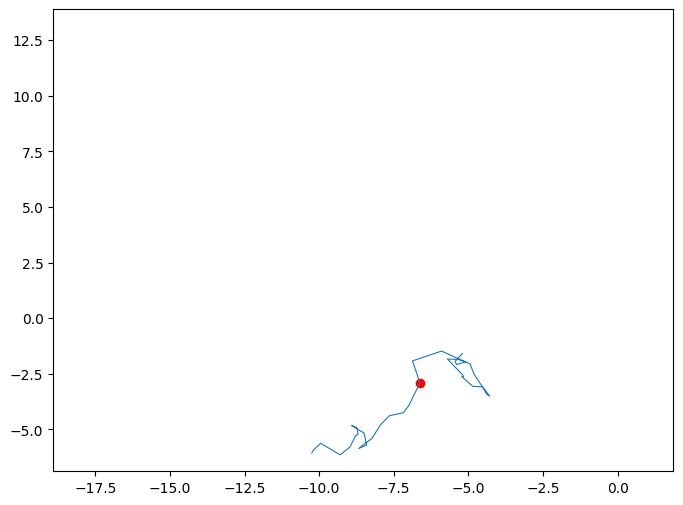

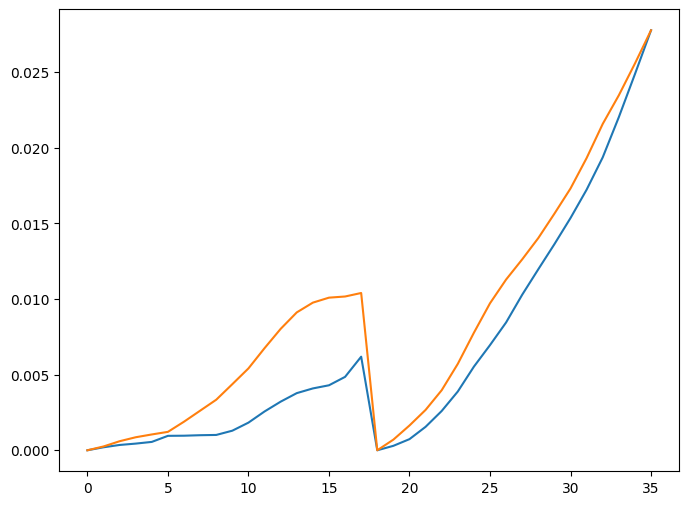

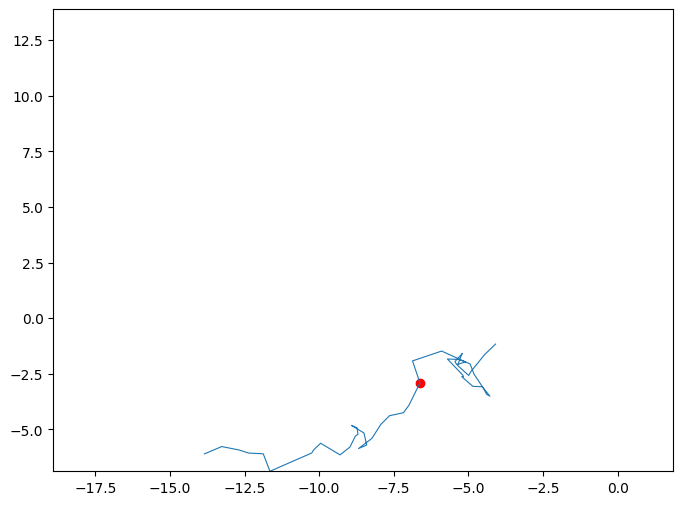

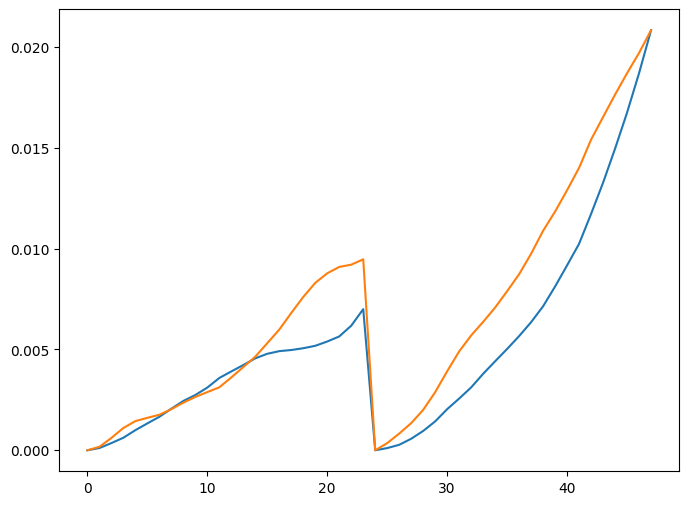

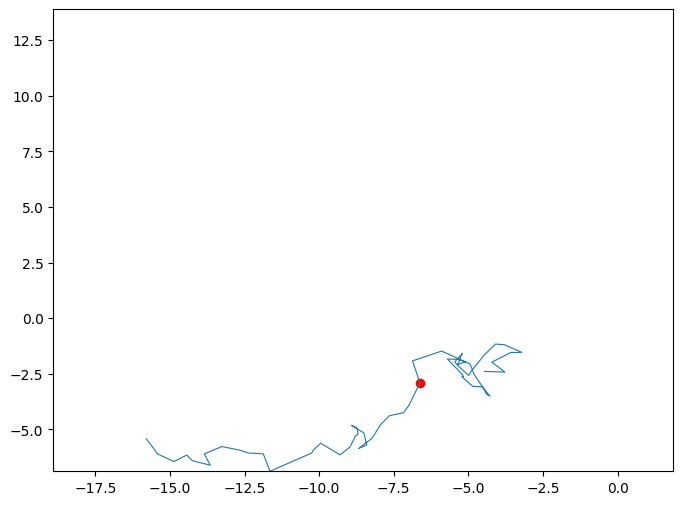

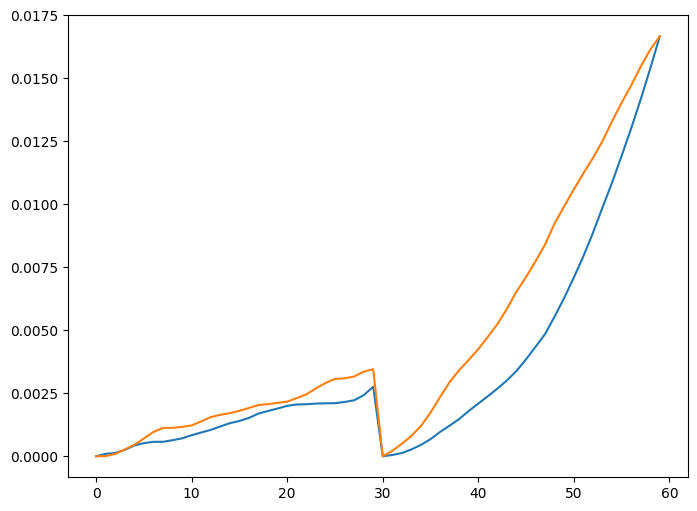

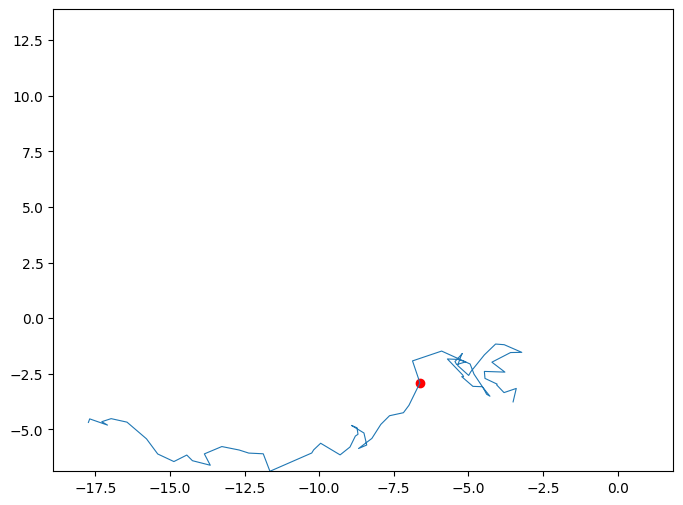

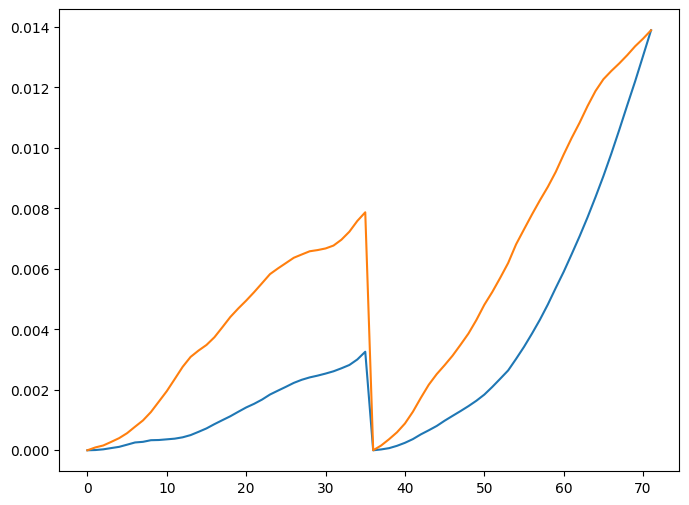

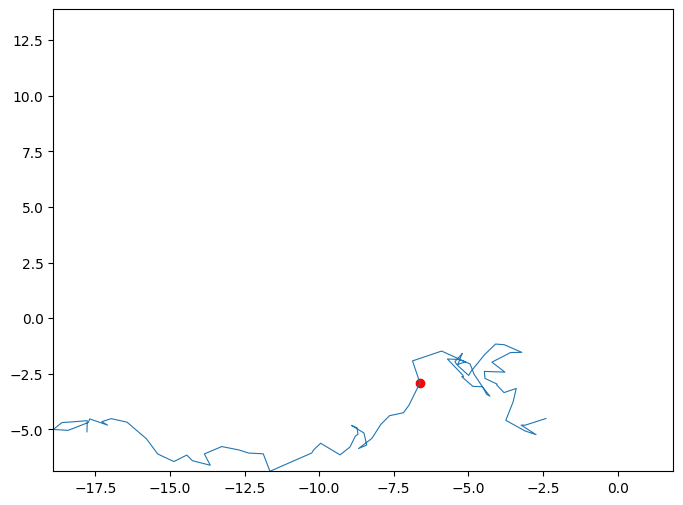

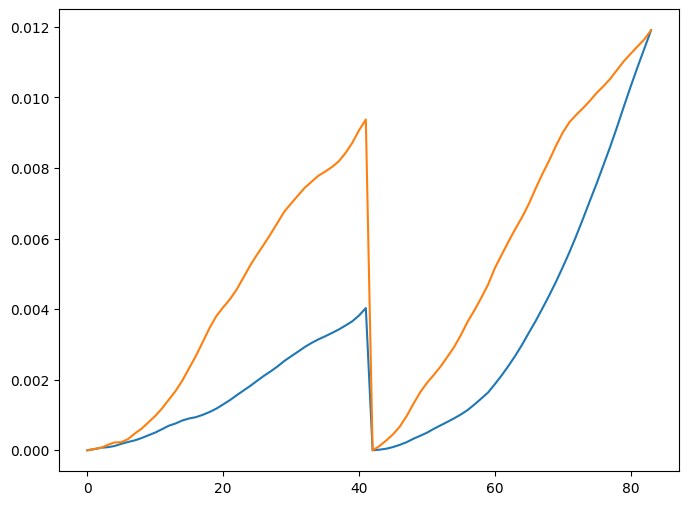

In [47]:
checkpoint = 110
val = []
for WINDOW_WIDTH, c in zip(WINDOW_WIDTHS, COLORS):
    if checkpoint - int(WINDOW_WIDTH/2) >= 0 and checkpoint + int(WINDOW_WIDTH/2) <= len(trajs_model[:, 0, 0]):
        xs = trajs_model[:, 0, 0][checkpoint - int(WINDOW_WIDTH/2) : checkpoint + int(WINDOW_WIDTH/2)]
        ys = trajs_model[:, 0, 1][checkpoint - int(WINDOW_WIDTH/2) : checkpoint + int(WINDOW_WIDTH/2)]

        plt.figure()
        plt.plot(xs, ys, linewidth=0.8)
        plt.scatter(xs[int(WINDOW_WIDTH/2)], ys[int(WINDOW_WIDTH/2)], c='red')

        plt.xlim([np.min(trajs_model[:, 0, 0]),
              np.min(trajs_model[:, 0, 0]) + max(np.max(trajs_model[:, 0, 0]) - np.min(trajs_model[:, 0, 0]), 
                np.max(trajs_model[:, 0, 1]) - np.min(trajs_model[:, 0, 1]))])
        plt.ylim([np.min(trajs_model[:, 0, 1]),
                  np.min(trajs_model[:, 0, 1]) + max(np.max(trajs_model[:, 0, 0]) - np.min(trajs_model[:, 0, 0]), 
                    np.max(trajs_model[:, 0, 1]) - np.min(trajs_model[:, 0, 1]))])


        #xs = xs / (np.std(xs))
        #xs = np.cumsum((uncumulate(xs)))
        #ys = ys / (np.std(ys))
        #ys = np.cumsum((uncumulate(ys)))
        #xs = uncumulate(xs)
        #ys = uncumulate(ys)

        xs1 = xs[:int(len(xs)/2)] - float(xs[:int(len(xs)/2)][0])
        xs2 = xs[int(len(xs)/2):] - float(xs[int(len(xs)/2):][0])
        #xs1 = abs(xs1)
        #xs2 = abs(xs2)

        ys1 = ys[:int(len(ys)/2)] - float(ys[:int(len(ys)/2)][0])
        ys2 = ys[int(len(ys)/2):] - float(ys[int(len(ys)/2):][0])

        std_xs1 = np.std(xs1)
        std_xs2 = np.std(xs2)
        std_ys1 = np.std(ys1)
        std_ys2 = np.std(ys2)

        surface_xs1 = abs(np.sum(xs1)) / WINDOW_WIDTH
        surface_xs2 = abs(np.sum(xs2)) / WINDOW_WIDTH
        surface_ys1 = abs(np.sum(ys1)) / WINDOW_WIDTH
        surface_ys2 = abs(np.sum(ys2)) / WINDOW_WIDTH


        xs1 = np.cumsum(abs(xs1)) #* surface_xs1
        xs2 = np.cumsum(abs(xs2)) #* surface_xs2
        ys1 = np.cumsum(abs(ys1)) #* surface_ys1
        ys2 = np.cumsum(abs(ys2)) #* surface_ys2


        xs_max_val = max(np.max(abs(xs1)), np.max(abs(xs2)))
        xs1 = xs1 / xs_max_val
        xs2 = xs2 / xs_max_val
        xs1 = xs1 / WINDOW_WIDTH
        xs2 = xs2 / WINDOW_WIDTH

        ys_max_val = max(np.max(abs(ys1)), np.max(abs(ys2)))
        ys1 = ys1 / ys_max_val
        ys2 = ys2 / ys_max_val
        ys1 = ys1 / WINDOW_WIDTH 
        ys2 = ys2 / WINDOW_WIDTH


        """
        xs1 = uncumulate(xs1)
        xs2 = uncumulate(xs2)
        ys1 = uncumulate(ys1)
        ys2 = uncumulate(ys2)

        #print((np.sum(xs1 - xs2))**2 + (np.sum(ys1 - ys2))**2)
        vals.append((abs(np.sum(xs1)) - abs(np.sum(xs2)))**2 + (abs(np.sum(ys1)) - abs(np.sum(ys2)))**2)
        """

        #vals.append(((abs(np.sum(xs1)) - abs(np.sum(xs2)))**2 + (abs(np.sum(ys1)) - abs(np.sum(ys2)))**2))
        #vals.append(np.sum((xs1 - ys1)**2 + (xs2 - ys2)**2))
        #val.append(np.sum((xs1 - xs2)**2 + (ys1 - ys2)**2))
        #val.append(abs((xs1[-1]- xs2[-1]) + (ys1[-1] - ys2[-1])))
        #val.append(abs(np.sum(xs1 - xs2) + np.sum(ys1 - ys2)))
        #val.append(abs((surface_xs1 - surface_xs2) + (surface_ys1 - surface_ys2)))
        #val.append(abs((xs1[-1]- xs2[-1]) + (ys1[-1] - ys2[-1])))
        print(np.sum(xs1 - xs2), np.sum(ys1 - ys2))
        print(std_xs1, std_xs2, std_ys1, std_ys2)
        #val.append(abs(np.sum(xs1 - xs2)*(max(std_xs1, std_xs2) - min(std_xs1, std_xs2)) 
        #               + np.sum(ys1 - ys2)*(max(std_xs1, std_xs2) - min(std_xs1, std_xs2))))
        #val.append(abs((np.sum(xs1 - xs2))*(max(std_xs1, std_xs2) - min(std_xs1, std_xs2)) 
        #               + (np.sum(ys1 - ys2))*(max(std_ys1, std_ys2) - min(std_ys1, std_ys2))))
        val.append(abs(np.sum(xs1 - xs2) + np.sum(ys1 - ys2)) 
                   * abs((max(std_xs1, std_xs2) / min(std_xs1, std_xs2)) 
                         * (max(std_ys1, std_ys2) / min(std_ys1, std_ys2))))

        #print((np.sum(xs1 - xs2))**2 + (np.sum(ys1 - ys2))**2)
        #val.append((abs(np.sum(xs1)) - abs(np.sum(xs2)))**2 + (abs(np.sum(ys1)) - abs(np.sum(ys2)))**2)

        #xs1 = xs1 / np.std(xs1)
        #xs2 = xs2 / np.std(xs2)
        #ys1 = ys1 / np.std(ys1)
        #ys2 = ys2 / np.std(ys2)

        #xs1 = np.cumsum(xs1)
        #xs2 = np.cumsum(xs2)
        #ys1 = np.cumsum(ys1)
        #ys2 = np.cumsum(ys2)
        #ys1 = abs(ys1)
        #ys2 = abs(ys2)

        """
        xs1 = xs1 / np.sum(xs1)
        xs2 = xs2 / np.sum(xs2)
        ys1 = ys1 / np.sum(ys1)
        ys2 = ys2 / np.sum(ys2)
        """
        """
        if np.sum(xs1) > np.sum(xs2):
            x_gap = abs(xs1 - xs2)
        else:
            x_gap = abs(xs2 - xs1)

        if np.sum(ys1) > np.sum(ys2):
            y_gap = abs(ys1 - ys2)
        else:
            y_gap = abs(ys2 - ys1)

        print(np.sum((x_gap - np.arange(WINDOW_WIDTH/2)**2/np.max(np.arange(WINDOW_WIDTH/2)**2))**2
                     + (y_gap - np.arange(WINDOW_WIDTH/2)**2/np.max(np.arange(WINDOW_WIDTH/2)**2))**2))
        """

        my_xs = np.concatenate((xs1, xs2))
        my_ys = np.concatenate((ys1, ys2))

        plt.figure()
        plt.plot(np.arange(WINDOW_WIDTH), my_xs )
        plt.plot(np.arange(WINDOW_WIDTH), my_ys )
print(val)
print(np.log(val[0] * val[1] * val[2]))